<a href="https://colab.research.google.com/github/MykhailoFokin/MachineLearning/blob/master/Naive_Bayes_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

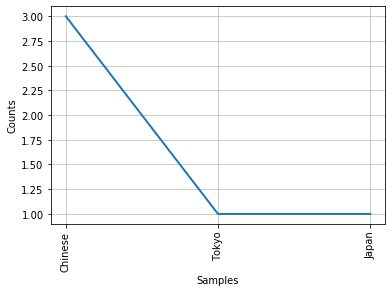

{'0': 0.00030121377997263036, '1': 0.00013548070246744223}
Log10 : {d} {'0': -3.5211251638485592, '1': -3.868122560204681}
Log : {d} {'0': -8.107690312843909, '1': -8.906681345001262}
Log2 : {d} {'0': -11.696924607403396, '1': -12.849625007211563}
Log1p : {d} {'0': 0.00030116842420963296, '1': 0.00013547152578590452}
Exp : {d} {'0': 1.0003012591493985, '1': 1.0001354898803922}
Expm1 : {d} {'0': 0.0003012591493984375, '1': 0.0001354898803922853}


In [70]:
# Basic test of algorithm (clear nltk with defaults)
# Move further to the next block for full implementation
from collections import Counter
import itertools
import math
import nltk
import copy
# nltk.download("popular")

# Train data
data = [["Chinese Beijing Chinese","0"],
        ["Chinese Chinese Shanghai","0"], 
        ["Chinese Macao","0"],
        ["Tokyo Japan Chinese","1"]]

class_count = {}
class_count_all = float(len(data))
word_count_all = {}
class_words_count = {}
wc_by_class = {item[1]: {} for item in data}
class_probability_template = copy.deepcopy(wc_by_class)
class_words_count = {item[1]: float(0) for item in data}
for line in data:
  if line[1] in class_count:
    class_count[line[1]] += 1
  else :
    class_count[line[1]] = float(1)
  tokenized_word=nltk.word_tokenize(line[0])
  fdist = nltk.FreqDist(tokenized_word)
  #fdist = nltk.FreqDist(w.lower() for w in tokenized_word)
  for word in fdist:
    #words_all += 1   # increase words counter
    class_words_count[line[1]] += fdist[word]
    # add/update word to class
    if word in wc_by_class[line[1]]:
      wc_by_class[line[1]][word] += fdist[word]
    else:
      wc_by_class[line[1]][word] = float(fdist[word])
    # add/update word to summary dict
    if word in word_count_all :
      word_count_all[word] += fdist[word]
    else :
      word_count_all[word] = float(fdist[word])
  #tokenized_words.append((dict(fdist), {"class" : line[1]}))

def calculate_conditional_probability(wc,count_c,v):
  '''
  == Input ==

  wc      : certain word count in appropriate class\n
  count_c : overall word count in appropriate class\n
  v       : unique word count in all classes
  
  == Output ==  
  result : probability for certain word for certain class
  '''
  return (1 + wc)/(count_c + v)

# Test
new = ["Chinese Chinese Chinese Tokyo Japan"]

tokenized_word=nltk.word_tokenize(new[0])
fdist = nltk.FreqDist(tokenized_word)
#print(Counter(tok['KeyName'] for tok in fdist))
x = 0
for key in wc_by_class:
  #print("Key of main dictionary: " + key)
  class_probability = class_count[key]/class_count_all
  for word in fdist:
    p1 = wc_by_class[key][word] if word in wc_by_class[key] else float(0)
    p2 = class_words_count[key]
    p3 = len(word_count_all)
    class_probability *= pow(calculate_conditional_probability(p1,p2,p3),fdist[word])
  #print("Class", key, class_probability)
  class_probability_template[key] = class_probability


# Frequency Distribution Plot
#FdistPrint = fdist.most_common(20) # take 20 most common words
fdist = dict(fdist)
fdist = nltk.FreqDist(fdist)
fdist.plot(10,cumulative=False)

#lists = sorted(fdist.items())
#x, y = zip(*lists)
#plt.plot(x, y)
#plt.show()

print(class_probability_template)
print("Log10 : {d}", {k: math.log10(v) for k, v in class_probability_template.items()})
print("Log : {d}", {k: math.log(v) for k, v in class_probability_template.items()})
print("Log2 : {d}", {k: math.log2(v) for k, v in class_probability_template.items()})
print("Log1p : {d}", {k: math.log1p(v) for k, v in class_probability_template.items()})
print("Exp : {d}", {k: math.exp(v) for k, v in class_probability_template.items()})
print("Expm1 : {d}", {k: math.expm1(v) for k, v in class_probability_template.items()})

In [1]:
# NLTK preparation
# Run it to get basic library content for futher usage
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [2]:
# install additional dependecy
pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=164083531a3857e8cf99c345fcec2107fa63769b684520fcdc1ea7ce87c50668
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
# Import block
import nltk
#from collections import Counter
import itertools
import math
import copy
import matplotlib.pyplot as plt
from stop_words import get_stop_words
import numpy as np
from sklearn.model_selection import train_test_split
import csv
import operator

# Define block
class NaiveBayes :

  def __init__ (self) :
    self.ClassCount = {}
    self.word_count_all = {}
    self.ElementsByClass = {}  #   class_words_count = {}
    #wc_by_class = {item[1]: {} for item in data}
    # from stop_words import get_stop_words 
    # stop_words = list(get_stop_words('en'))  # About 900 words
    # from nltk.corpus import stopwords
    # list(stopwords.words('english')) # About 150 stopwords
    # stop_words.extend(nltk_words)
    self.stopwords = set(nltk.corpus.stopwords.words("english")) # import stopwords and remove duplicates
    self.AccuracyMatrix = []
    self.Accuracy = float(0)
    self.AccuracyPredictions = []
    self.PredictionsProbabilities = []
    self.AccuracyPredictionsTest = False

    self.change_stopwords_list("Extended")

  def change_stopwords_list(self, whatlist = 'Default') :
    '''
    Optionally we can change default Enlgish stop words from NLTK

    == Input ==

    whatlist : string parameter for certain stop words list\n
       Default : Use only NLTK list. About 150 stopwords
       Alternative : Use stop_words library. About 900 words
       Extended : Use both together
    '''
    if whatlist == 'Default' :
      self.stopwords = set(nltk.corpus.stopwords.words("english")) # import stopwords and remove duplicates
    elif whatlist == 'Alternative' :
      self.stopwords = set(get_stop_words('en')) # import stopwords and remove duplicates
    elif whatlist == 'Extended' :
      nltkstopwords = list(nltk.corpus.stopwords.words("english"))
      stop_words = list(get_stop_words('en'))
      stop_words.extend(nltkstopwords)
      self.stopwords = set(stop_words)

  def tokenize_string(self, input_string, tokenizer_type=0):
    '''
    Split string into tokens.

    == Input ==

    input_string : string parameter for certain stop words list\n
    tokenizer_type : how split string into words, what tokenizer rules should it use\n
       0 : Default value, it will use default delimiters with function nltk.word_tokenize\n
       1 : It will picks out sequences of alphanumeric characters as tokens and drops everything else.\n
           nltk.tokenize.RegexpTokenizer function
    '''
    tokenized_string = []
    #print(input_string)
    if tokenizer_type == 1:
      tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
      tokenized_string = tokenizer.tokenize(input_string)
    else :
      tokenized_string = nltk.word_tokenize(input_string)
    #print(tokenized_string)
    return tokenized_string

  def split_traint_test(self, input_data) :
    if len(input_data)<10 :
      #test_size = len(input_data)
      return input_data, input_data
    elif (len(input_data)>10000) :
      test_size = 2000
    else :
      test_size = (int(len(input_data)*0.2) or 1)
    #print(len(input_data[:test_size]))
    #print(len(input_data[test_size:]))
    return input_data[:test_size], input_data[test_size:]

  def fit(self, input_data, use_stop_words, use_stemming, use_alphanumeric, print_word_distribution) :
    '''
    Takes input_data and apply on it Naive Bayes algorithm.\n
    Input will be separated depends on how many elements in the list,\n
    not more than 2,000 elements will be taken as a test list.\n
    The result of this method is accuracy of predictions based on splitting\n
    Input dataset into train and test and applying algorithm on it.

    == Input ==

    input_data : string parameter for certain stop words list\n
    use_stop_words   : (False,True) Should be apply filtering out stopwords
    use_stemming     : (False,True) Should it also uses lexicon(linguistic) normalization
    use_alphanumeric : (False,True) Should non alphanumeric symbols be excluded
    '''
    #self.ClassCount = 
    self.ClassCountAll = float(len(input_data))  # class_count_all = float(len(data))
    self.ElementsByClass = {item[1]: float(0) for item in input_data}
    self.WordsByClass = {item[1]: {} for item in input_data}
    self.ClassProbabilityResult = copy.deepcopy(self.WordsByClass)
    self.UseStopWords = use_stop_words
    self.UseStemming = use_stemming
    self.AlphaNumeric = 1 if use_alphanumeric else 0
    self.AccuracyMatrix = []
    self.Accuracy = 0
    self.AccuracyPredictions = []
    self.AccuracyPredictionsTest = False
    self.word_count_all = {}

    self.test_data, self.train_data = self.split_traint_test(input_data)

    #for line in input_data:
    for line in self.train_data:
      if line[1] in self.ClassCount:
        self.ClassCount[line[1]] += 1
      else :
        self.ClassCount[line[1]] = float(1)
      #tokenized_word = nltk.word_tokenize(line[0])
      tokenized_word = self.tokenize_string(line[0],1)
      
      #filtered_words = [word for word in tokenized_word if word not in stopwords.words('english')]
      if use_stop_words :
        tokenized_word = self.removing_stop_words(tokenized_word)
      if use_stemming :
        tokenized_word = self.stemming(tokenized_word)
      fdist = nltk.FreqDist(tokenized_word)
      
      #fdist = nltk.FreqDist(w.lower() for w in filtered_words) # stopwords in nltk in lowercase
      #filtered_words = [word for word in fdist if word not in stopwords.words('english')]
      for word in fdist:
        self.ElementsByClass[line[1]] += fdist[word]
        # add/update word to class
        if word in self.WordsByClass[line[1]]:
          self.WordsByClass[line[1]][word] += fdist[word]
        else:
          self.WordsByClass[line[1]][word] = float(fdist[word])
        # add/update word to summary dict
        if word in self.word_count_all :
          self.word_count_all[word] += fdist[word]
        else :
          self.word_count_all[word] = float(fdist[word])
    
    # Prediction block (Predict, Evaluate, Calculate accuracy)
    #accuracy_matrix = []
    #for test_line in self.test_data:
    #  prediction_probabilities = self.predict_one(test_line)
    #  self.AccuracyPredictions.append(max(prediction_probabilities.items(), key=operator.itemgetter(1))[0])
    #  self.AccuracyMatrix.append(test_line[1] == max(prediction_probabilities.items(), key=operator.itemgetter(1))[0])
    #self.Accuracy = np.sum(self.AccuracyMatrix)/len(self.AccuracyMatrix)

    if print_word_distribution:
      self.print_freq_distrinbution(self.word_count_all)
    self.predict(self.test_data)
    self.AccuracyPredictionsTest = copy.deepcopy(self.AccuracyPredictions)
    self.AccuracyMatrixTest = copy.deepcopy(self.AccuracyMatrix)
    print_word_distribution = False

    self.Accuracy = np.sum(self.AccuracyMatrix)/len(self.AccuracyMatrix)

    return self.Accuracy

  def print_errors(self, accuracy_matrix, predictions_matrix, source_data):
    if accuracy_matrix : # check that it is not empty
      print("Errors during training : ")
      for i in range(len(accuracy_matrix)) :
        print("Source class : {d} , Predicted class : {d}, Message : {s}", source_data[i][1], predictions_matrix[i], source_data[i][0])

  def print_training_errors(self):
    self.print_errors(self, self.AccuracyMatrixTest, self.AccuracyPredictionsTest, self.test_data)

  def predict(self, input_data) :
    self.PredictionsProbabilities = []
    self.AccuracyPredictions = []
    self.AccuracyMatrix = []
    for test_line in input_data:
      prediction_probabilities = self.predict_one(test_line)
      self.PredictionsProbabilities.append(prediction_probabilities)
      self.AccuracyPredictions.append(max(prediction_probabilities.items(), key=operator.itemgetter(1))[0])
      self.AccuracyMatrix.append(test_line[1] == max(prediction_probabilities.items(), key=operator.itemgetter(1))[0])
      #print(max(prediction_probabilities.items(), key=operator.itemgetter(1))[0])
    #self.Accuracy = np.sum(np.array(self.AccuracyMatrix))/len(self.AccuracyMatrix)
    if self.AccuracyPredictionsTest :
      #print_errors(self.AccuracyMatrix, self.AccuracyPredictionsTest, input_data) # if this isn't called from FIT then print predictions
      print(self.PredictionsProbabilities)

  def predict_one(self, input_string) :
    tokenized_test = self.tokenize_string(input_string[0],1)
    if self.UseStopWords :
      tokenized_test = self.removing_stop_words(tokenized_test)
    if self.UseStemming :
      tokenized_test = self.stemming(tokenized_test)
    fdist_test = nltk.FreqDist(tokenized_test)
    #tokenized_word=nltk.word_tokenize(new[0])
    #fdist = nltk.FreqDist(tokenized_word)
    #x = 0
    for key in self.WordsByClass:
      self.ClassProbabilityResult[key] = float(0) # set to 0 if there is previuos result 
      class_probability = self.ClassCount[key]/self.ClassCountAll
      for word in fdist_test:
        p1 = self.WordsByClass[key][word] if word in self.WordsByClass[key] else float(0)
        p2 = self.ElementsByClass[key]
        p3 = len(self.word_count_all)
        #class_probability *= pow(self.calculate_conditional_probability(p1,p2,p3),(fdist_test[word] or 1))
        class_probability += math.log10(pow(self.calculate_conditional_probability(p1,p2,p3),(fdist_test[word] or 1)))
      #self.ClassProbabilityResult[key] = math.log10(class_probability)
      self.ClassProbabilityResult[key] = class_probability
    return self.ClassProbabilityResult

  def print_freq_distrinbution(self, fdist):
    # Frequency Distribution Plot
    #FdistPrint = fdist.most_common(20) # take 20 most common words
    #fdist.plot(30,cumulative=False)
    #print(fdist)
    lists = sorted(fdist.items())
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.show()

  def removing_stop_words(self, tokenized_string) :
    '''
    Removing stop words from tokenized string (dict of words)

    == Input ==

    tokenized_string : dict of tokens (dictionary of words from splitted string)
    
    == Output ==  

    filtered_tokens : dict of filtered words in lowercase
    '''
    filtered_tokens = []
    for word in tokenized_string:
      word = word.lower() # in case they arenet all lower cased
      if word not in self.stopwords : #.words("english"):
        filtered_tokens.append(word)
    #return [word for word in word_list if word not in self.stopwords.words('english')]
    return filtered_tokens
  
  def stemming(self, tokenized_string) :
    '''
    Stemming\n
    Stemming is a process of linguistic normalization, which reduces words
    to their word root word or chops off the derivational affixes.
    For example, connection, connected, connecting word reduce to a common word "connect".

    == Input ==

    fdsit : dict of tokens (dictionary of words from splitted string)
    
    == Output ==  

    stemmed_tokens : dict of preprocessed words
    '''

    ps = nltk.stem.PorterStemmer()

    stemmed_words=[]
    for w in tokenized_string:
        stemmed_words.append(ps.stem(w))

    return stemmed_words

  def calculate_conditional_probability(self,wc,count_c,v):
    '''
    == Input ==

    wc      : certain word count in appropriate class\n
    count_c : overall word count in appropriate class\n
    v       : unique word count in all classes
    
    == Output ==  
    result : probability for certain word for certain class
    '''
    return (1 + wc)/(count_c + v)

In [6]:
# Test of sample data
# Part 1
# Copy test data from repo (do it once)
!git clone https://github.com/MykhailoFokin/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 148 (delta 14), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (148/148), 39.65 MiB | 9.47 MiB/s, done.
Resolving deltas: 100% (80/80), done.


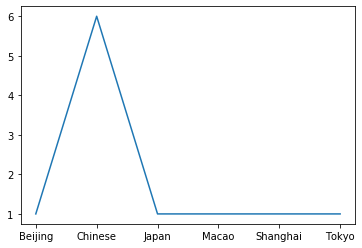

Accuracy : 1.0 
[{'0': -0.3961280356782382, '1': -0.7042425094393249}]


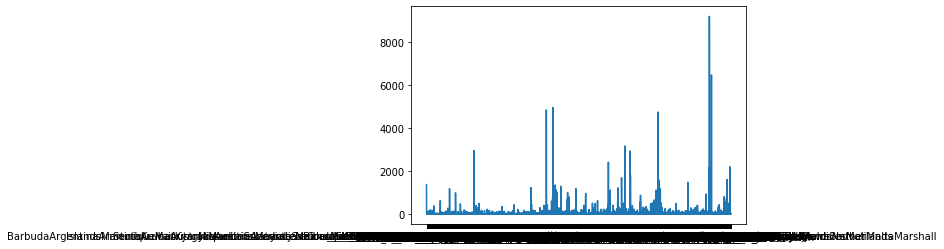

Accuracy : 0.9327354260089686 


In [0]:
# Test of sample data
# Part 2
# Create instance of NaiveBayes class
nb = NaiveBayes()

source_data_list = []

# Train data
simple_data = [["Chinese Beijing Chinese","0"],
        ["Chinese Chinese Shanghai","0"], 
        ["Chinese Macao","0"],
        ["Tokyo Japan Chinese","1"]]

Accuracy = nb.fit(simple_data, False, False, False, True)  # return accuracy
print("Accuracy : {0} ".format(Accuracy))
nb.predict(["Chinese Chinese Chinese Tokyo Japan"])


with open('MachineLearning/Naive_Bayes_data_test.csv', 'r') as f:
    reader = csv.reader(f)
    #for row in reader :
      #source_data_list.append(row)
    source_data_list = list(reader) # Train data

# Create instance of NaiveBayes class
#nb = NaiveBayes()

# Train our model
# Tips: inside fit method it would be nice to split input data into train / test (80/20) sets and return model’ accuracy, e.g.:
Accuracy = nb.fit(source_data_list, False, False, False, True)  # return accuracy
print("Accuracy : {0} ".format(Accuracy))
Accuracy = nb.fit(source_data_list, True, False, False, True)  # return accuracy 
print("Accuracy with stopwords : {0} ".format(Accuracy))
Accuracy = nb.fit(source_data_list, True, True, False, True)  # return accuracy 
print("Accuracy with stopwords, stemming: {0} ".format(Accuracy))
Accuracy = nb.fit(source_data_list, True, True, True, True)  # return accuracy 
print("Accuracy with stopwords, stemming, filtering out non alphanumeric symbols: {0} ".format(Accuracy))

# Try to predict class of text
nb.predict(["Chinese Chinese Chinese Tokyo Japan"])

# Must return[ ('Chinese Chinese Chinese Tokyo Japan', '0')]
# pobability {'1': 0.00013548070246744226, '0': 0.00030121377997263036}
# or log     {'1': -7.906681345001262, '0': -7.10769031284391}


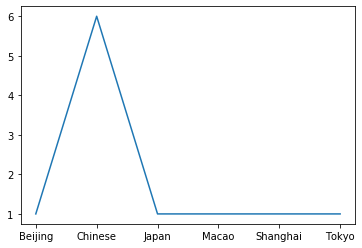

Accuracy : 1.0 
[{'0': -0.3961280356782382, '1': -0.7042425094393249}]


In [140]:
nb = NaiveBayes()

# Train data
simple_data = [["Chinese Beijing Chinese","0"],
        ["Chinese Chinese Shanghai","0"], 
        ["Chinese Macao","0"],
        ["Tokyo Japan Chinese","1"]]

Accuracy = nb.fit(simple_data, False, False, False, True)  # return accuracy
print("Accuracy : {0} ".format(Accuracy))
nb.predict(["Chinese Chinese Chinese Tokyo Japan"])